# **Data visualization**

## Objectives

* To provide an answer to the first business requirement: "To visually differentiate a cherry leaf that is healthy from one that contains powdery mildew."
* Calculate the average image size and prepare for modeling.
* Provide clear visuals that can be used in the clients dashboard.

## Inputs
**Folders:**
* inputs/cherry-leaf-dataset/cherry-leaves/test
* inputs/cherry-leaf-dataset/cherry-leaves/train
* inputs/cherry-leaf-dataset/cherry-leaves/validation

## Outputs

* Image shape embeddings as a pickle file.
* Average images and variability images for each class (healthy or powdery mildew).
* An overview/graph that visually differentiates a cherry leaf that is healthy from one that contains powdery mildew.
* Generate code that provides an answer to the first business requirement.

## Additional Comments

* The correct visualization of healty leaves vs. leaves containing powdery mildew is critical for creating easy to read visuals for the client.



---

# Notebook preparation

## Ensure correct requirements are installed

In [3]:
# installs all required packages for the project
%pip install -r /workspaces/cherry-leaves-mildew-detection/requirements.txt

Note: you may need to restart the kernel to use updated packages.


## Import libraries

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

## Set working directory

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [5]:
cwd= os.getcwd()

In [6]:
os.chdir('/workspaces/cherry-leaves-mildew-detection')
print("You set a new current directory:")
print(os.getcwd())

You set a new current directory:
/workspaces/cherry-leaves-mildew-detection


In [7]:
visual_dir = os.getcwd()
visual_dir

'/workspaces/cherry-leaves-mildew-detection'

Confirm the new current directory

In [8]:
visual_dir = os.getcwd()
print("current directory is:", visual_dir)

current directory is: /workspaces/cherry-leaves-mildew-detection


### Set input directories

In [9]:

my_data_dir = 'inputs/cherry-leaf-dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

### Set output directories

In [10]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(visual_dir) and version in os.listdir(visual_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


### Set label names

In [ ]:
# Set the labels
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['powdery_mildew', 'healthy']


# Data visualization of image data

**Compute Average Image Size for the Training Set**

Compute average image size on train set as was requested as part of Business requirement 1: "Calculate the average image size and prepare for modeling."

In Image Processing, it's beneficial to normalize image pixel values based on the dataset's mean and standard deviation. This ensures consistent model performance when applied to new images and is essential for transfer learning. However, calculating these statistics can be challenging because the entire dataset typically cannot be loaded into memory at once. Instead, it is necessary to process the dataset in batches to compute the required statistics.

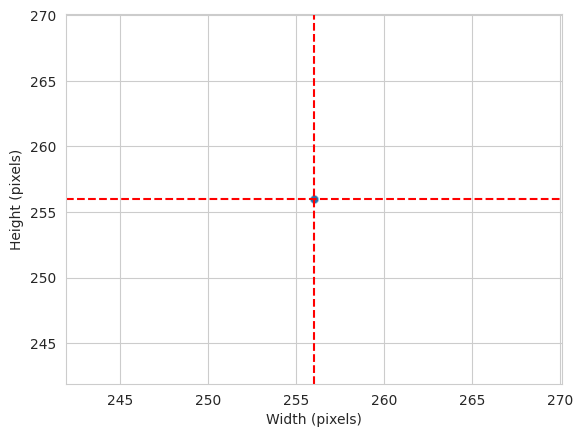

Height average: 256 
Width average: 256


In [13]:
# Calculate the average image dimensions (height and width) for the training set
# Read each image from the training directory and store its dimensions
# Plot a scatter plot of image dimensions and highlight the mean values with red dashed lines

image_height, image_width = [], []
for label in labels:
    for image_filename in os.listdir(train_path + '/' + label):
        img = imread(train_path + '/' + label + '/' + image_filename)
        d1, d2, colors = img.shape
        image_height.append(d1)
        image_width.append(d2)

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=image_width, y=image_height, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
image_height_mean = int(np.array(image_height).mean())
image_width_mean = int(np.array(image_width).mean())
axes.axvline(x=image_height_mean, color='r', linestyle='--')
axes.axhline(y=image_width_mean, color='r', linestyle='--')
plt.show()
print(f"Height average: {image_height_mean} \nWidth average: {image_width_mean}")

## Define image shape based on height, width and color (RGB)

In [14]:
# Define the shape of the images based on the average height and width,
# assuming a color image with 3 channels (RGB).
image_shape = (image_height_mean, image_width_mean, 3)

# Display the defined image shape
image_shape

(256, 256, 3)

### Save the image as pickle file

In [15]:
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

---

## Average and variability of images per label

In [16]:
# Function that loads and resizes images into an arry using tenserflow

from tensorflow.keras.preprocessing import image


def load_image_as_array(my_data_dir, new_size=(50, 50), n_images_per_label=20):

    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(my_data_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(my_data_dir + '/' + label):
            # n_images_per_label: we set a limit, since it may take too much time
            if counter < n_images_per_label:

                img = image.load_img(
                    my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)

                X = np.append(X, img_resized).reshape(-1, new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return X, y

### Load image shapes and labels in an array

In [17]:
X, y = load_image_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                           n_images_per_label=30)
print(X.shape, y.shape)

(60, 256, 256, 3) (60,)


### Plot and save mean and variability of images per label

In [ ]:
def plot_mean_variability_per_labels(X, y, figsize=(12, 5), save_image=False):
    # Loop over all labels
    for label_to_display in np.unique(y):
        sns.set_style("white")

        # Subset an array for a given label
        y = y.reshape(-1, 1, 1)
        boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
        arr = X[boolean_mask]

        # Calculate the mean and standard deviation
        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")
        
        # Create a figure displaying the mean and variability of images
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for label {label_to_display}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability image for label {label_to_display}")
        axes[1].imshow(std_img, cmap='gray')

        # Save the image
        if save_image:
            plt.savefig(f"{file_path}/avg_var_{label_to_display}.png",
                        bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")

==== Label healthy ====
Image Shape: (256, 256, 3)
==== Label powdery_mildew ====
Image Shape: (256, 256, 3)


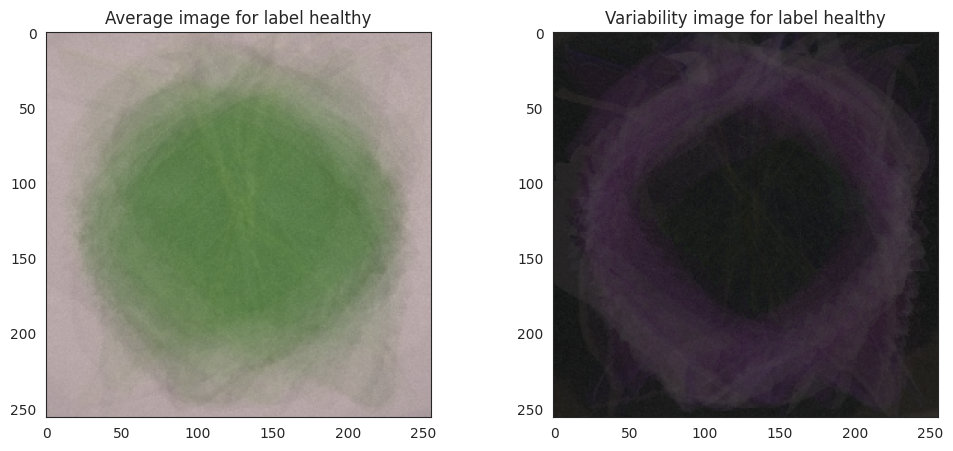

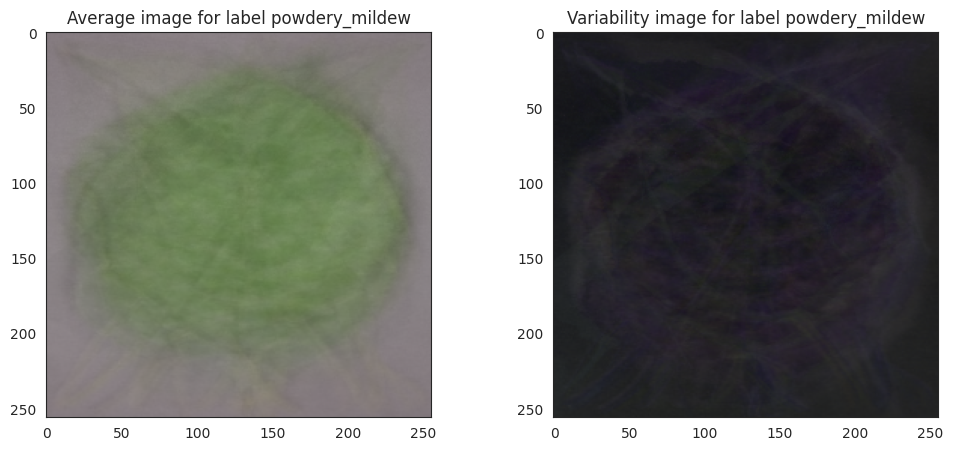

In [19]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(12, 5), save_image=True)

## Difference between average healthy leave and leave with mildew images

In [ ]:
# Extracts images corresponding to a specific label from the dataset.
def subset_image_label(X, y, label_to_display):
    y = y.reshape(-1, 1, 1)
    boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
    df = X[boolean_mask]
    return df

# Compare the average images of two labels and plot their difference.
def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(20, 5), save_image=False):
    """
    Checks if the labels exist in the set of unique labels
    Calculates the mean and difference for label1 and label2
    Plots a chart and saves it if save_image=True
    """
    sns.set_style("white")

    if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
        print(
            f"Either label {label} or label {label_2}, are not in {np.unique(y)} ")
        return

    # calculate mean from label1
    images_label = subset_image_label(X, y, label_1)
    label1_avg = np.mean(images_label, axis=0)

    # calculate mean from label2
    images_label = subset_image_label(X, y, label_2)
    label2_avg = np.mean(images_label, axis=0)

    # calculate difference and plot difference, avg label1 and avg label2
    difference_mean = label1_avg - label2_avg
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(label1_avg, cmap='gray')
    axes[0].set_title(f'Average {label_1}')
    axes[1].imshow(label2_avg, cmap='gray')
    axes[1].set_title(f'Average {label_2}')
    axes[2].imshow(difference_mean, cmap='gray')
    axes[2].set_title(f'Difference image: Avg {label_1} & {label_2}')
    if save_image:
        plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
    else:
        plt.tight_layout()  # Adjust layout for better spacing
        plt.show()          # Display the plots

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


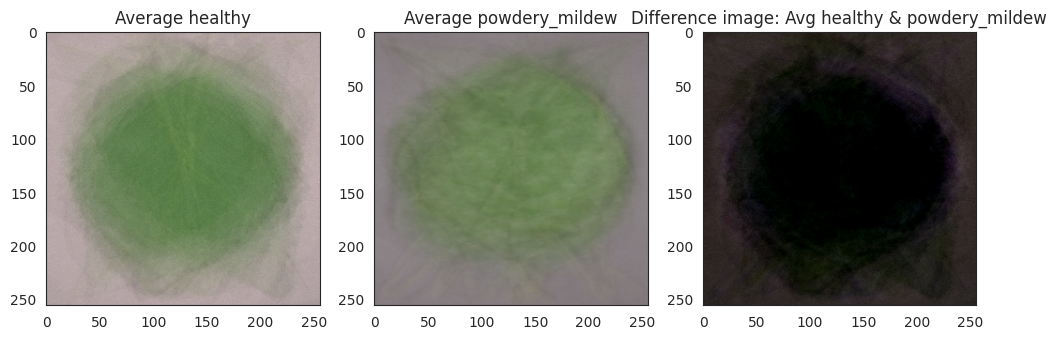

In [ ]:
# Call the function to compare the average images of healthy and powdery mildew-infected leaves,
# plotting their difference with a figure size of (12, 10) and saving the resulting plot as an image file.

diff_bet_avg_image_labels_data_as_array(X=X, y=y,
                                        label_1='healthy', label_2='powdery_mildew',
                                        figsize=(12, 10),
                                        save_image=True
                                        )

## Image Montage

In [23]:
import itertools
import random
sns.set_style("white")


def image_montage(dir_path, label_to_display, nrows, ncols, figsize=(15, 10)):
    """
    if the label exists in the directory
    check if your montage space is greater than the subset size
    create a list of axes indices based on nrows and ncols
    create a Figure and display images
    in this loop, load and plot the given image
    """

    labels = os.listdir(dir_path)

    # subset the class you are interested to display
    if label_to_display in labels:

        # checks if your montage space is greater than the subset size
        images_list = os.listdir(dir_path + '/' + label_to_display)
        if nrows * ncols < len(images_list):
            img_idx = random.sample(images_list, nrows * ncols)
        else:
            print(
                f"Decrease nrows or ncols to create your montage. \n"
                f"There are {len(images_list)} in your subset. "
                f"You requested a montage with {nrows * ncols} spaces")
            return

        # create a list of axes indices based on nrows and ncols
        list_rows = range(0, nrows)
        list_cols = range(0, ncols)
        plot_idx = list(itertools.product(list_rows, list_cols))

        # create a Figure and display images
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        for x in range(0, nrows*ncols):
            img = imread(dir_path + '/' + label_to_display + '/' + img_idx[x])
            img_shape = img.shape
            axes[plot_idx[x][0], plot_idx[x][1]].imshow(img)
            axes[plot_idx[x][0], plot_idx[x][1]].set_title(
                f"Width {img_shape[1]}px x Height {img_shape[0]}px")
            axes[plot_idx[x][0], plot_idx[x][1]].set_xticks([])
            axes[plot_idx[x][0], plot_idx[x][1]].set_yticks([])
        plt.tight_layout()
        plt.show()

    else:
        print("The label you selected doesn't exist.")
        print(f"The existing options are: {labels}")

powdery_mildew


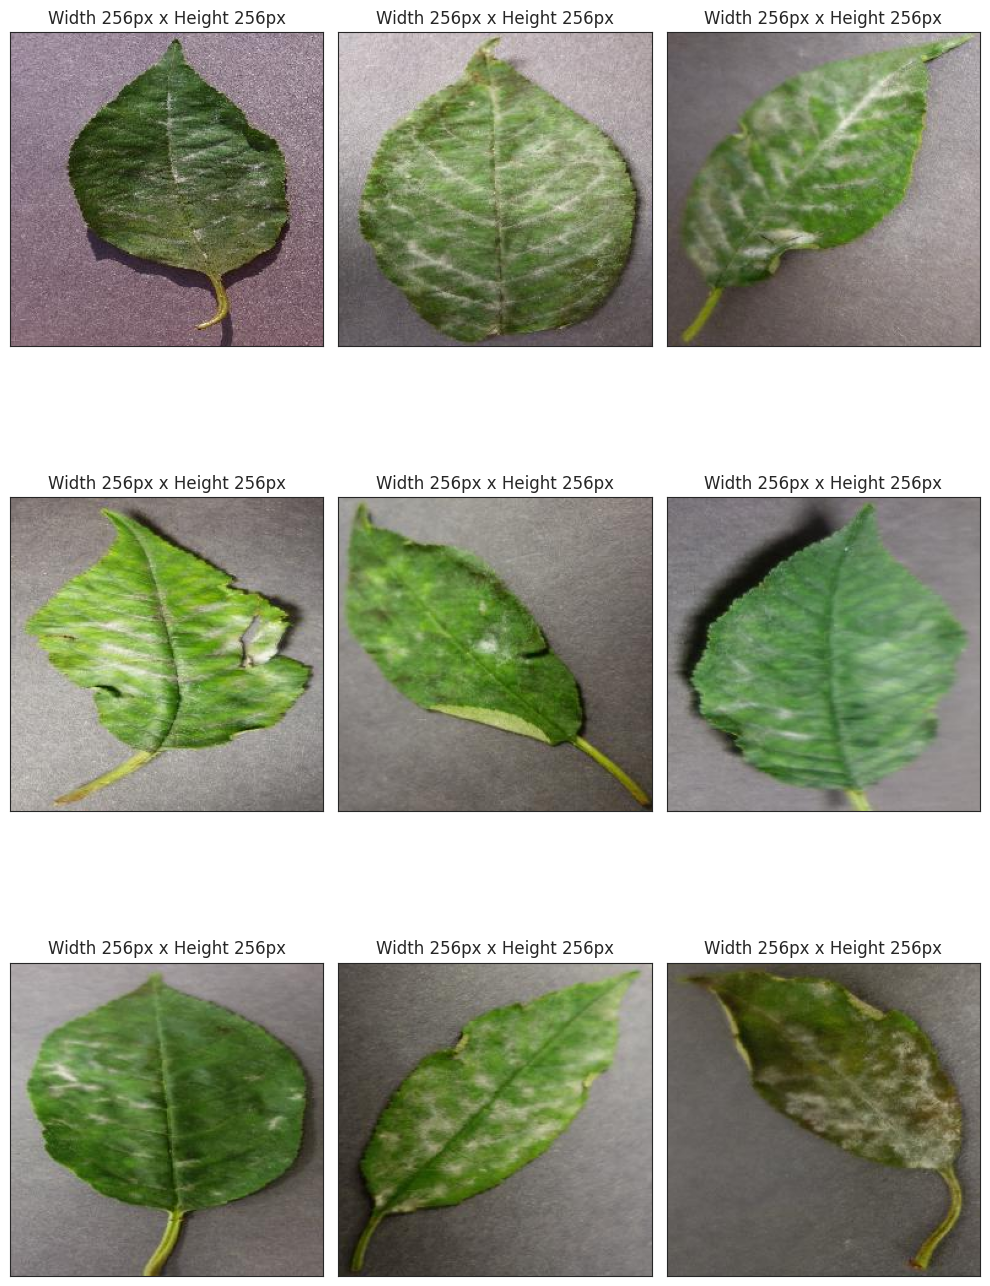



healthy


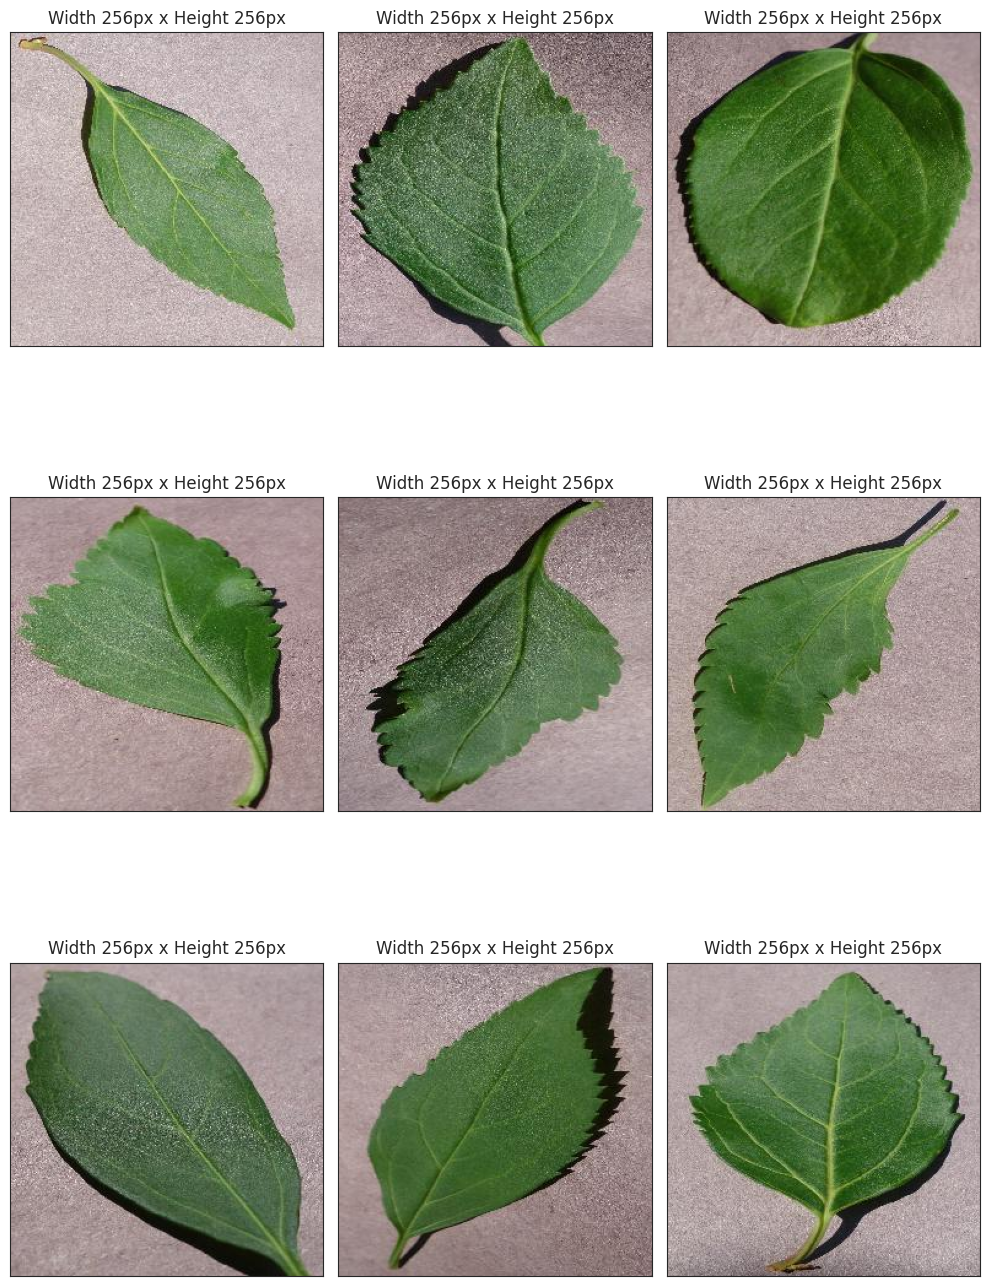

In [24]:
# Run Montage in all labels

for label in labels:
    print(label)
    image_montage(dir_path=train_path,
                  label_to_display=label,
                  nrows=3, ncols=3,
                  figsize=(10, 15)
                  )
    print("\n")

---

## Conclusion

The Objectives of this notebook were to:
* Answer business requirement 1:
  * Conduct a study to visually differentiate a healthy cherry leaf from a leaf infected with powdery mildew
  * Calculate the average image size of the cherry leaves for machine learning purposes.

This has been accomplised through:
* Correctly differentiate a healthy cherry leaf from a leaf infected with powdery mildew
* Correctly calculating the average image size of the cherry leaves

Visual observations:
* Healthy leaves are of a consistant and brighter green color, with strong lines and texture
* Leaves with mildew do not have a consistant green color (irregular), have unclear lines and have visually white collored textures, covering the leaves. This is also more prudent in the veins of the leaves.

# Next Steps

* As these images are clear and consistant, they can be used for modeling and training the predictive model

---